In [ ]:
!pip install qiskit[visualization] qiskit-ibm-runtime qiskit-aer qiskit_qasm3_import

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter, ParameterVector
import qiskit.qasm3
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RXGate
from qiskit.circuit.library import CCXGate

In [ ]:
def input_board():
    print("Enter your Battleship grid row-by-row.")

    size = 5
    board = []

    print("\nEnter each row, separated by spaces:")
    for _ in range(size):
        row = input().split()
        row = [cell for cell in row]
        board.append(row)

    return board


def print_board(board, size, reveal=False):
    for r in range(size):
        display_row = []
        for c in range(size):
            if reveal:
                display_row.append(board[r][c])
            else:
                display_row.append("X" if board[r][c] == '1' else ".")
        print(" ".join(display_row))
    print()

board = input_board()

Enter your Battleship grid row-by-row.

Enter each row, separated by spaces:
1 1 0 1 0
0 0 1 0 1
0 0 0 0 0 
1 1 1 1 1
0 1 0 1 1


In [ ]:
def classical_brute_force(board, size):
  score = 0
  ships_total = sum(row.count("1") for row in board)

  for r in range(size):
      for c in range(size):
        if board[c][r] == "1":
            return score
        else:
            score += 1
  return score

print("input board:")
print_board(board, 5)
brute_force = classical_brute_force(board, 5)
print("Classical Minesweeper score:")
print(brute_force)

input board:
X X . X .
. . X . X
. . . . .
X X X X X
. X . X X

Classical Minesweeper score:
0


In [201]:
def test_primitives(cycles,bomb: bool,shots=1000,show=False):
  if not bomb:
    return (0, 0, 0)
  theta = np.pi / cycles

  qr = QuantumRegister(3, 'q')
  cr = ClassicalRegister(cycles + 1, 'c')
  qc = QuantumCircuit(qr, cr)

  qc.h(qr[0])

  for cycle in range(cycles - 1):
    qc.append(RXGate(theta), [qr[1]])
    qc.ccx(qr[0], qr[1], qr[2])
    qc.measure(qr[2], cr[cycle])

    if cycle < cycles - 2:
        qc.reset(qr[2])

  qc.append(RXGate(theta), [qr[1]])
  qc.measure(qr[1], cr[cycles - 1])
  qc.measure(qr[0], cr[cycles])

  simulator = AerSimulator()
  job = simulator.run(qc, shots=shots)
  result = job.result()
  counts = result.get_counts(qc)

  # if show:
  display(qc.draw('mpl'))
  display(plot_histogram(counts))

  safe_detections = 0
  bomb_detections = 0
  bomb_explosions = 0

  results = sorted(counts.keys())

  for r in results:
    for i in range(2,cycles):
      if int(r[i]) == 1:
        bomb_explosions += 1
        break
      if int(r[1]) == 0:
        bomb_detections += 1
      else:
        safe_detections += 1

  total_safe = safe_detections + bomb_detections

  if total_safe > 0:
    bomb_probability = bomb_detections / total_safe
  else:
    bomb_probability = 0

  return (bomb_probability, bomb_detections, bomb_explosions)

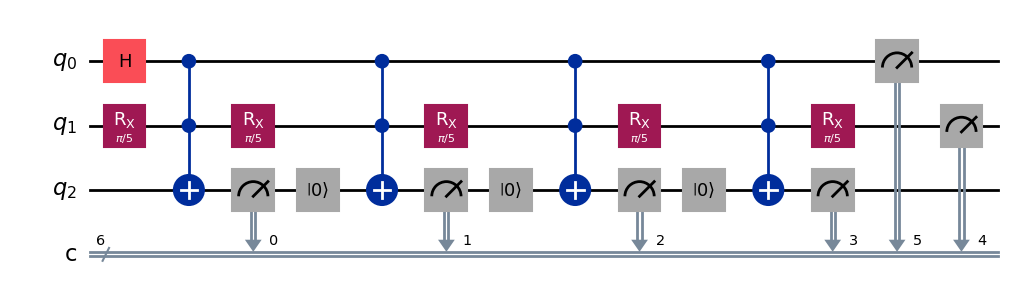

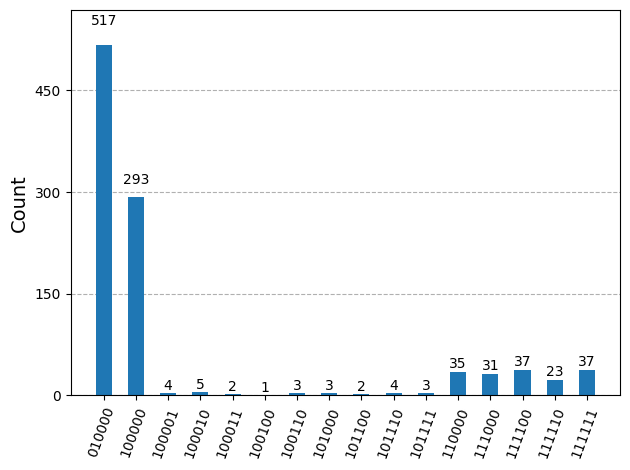

(0.6666666666666666, 12, 12)

In [202]:
test_primitives(5, True, 1000, True)

In [193]:
def quantum_plan(board, size):
  shots_per_cell = 1000
  cycles = 10
  total_bomb_explosions = 0
  total_bomb_detections = 0

  column_probs = []
  for j in range(size):
    has_ship = any(board[i][j] == '1' for i in range(size))
    (prob, bomb_detections, bomb_explosions) = test_primitives(cycles, has_ship, shots=shots_per_cell)
    column_probs.append(prob)
    total_bomb_explosions += bomb_explosions
    total_bomb_detections += bomb_detections

  row_probs = []
  for i in range(size):
    has_ship = any(board[i][j] == '1' for j in range(size))
    (prob, bomb_detections, bomb_explosions) = test_primitives(cycles, has_ship, shots=shots_per_cell)
    row_probs.append(prob)
    total_bomb_explosions += bomb_explosions
    total_bomb_detections += bomb_detections

  scores = [[0.0] * size for _ in range(size)]
  for i in range(size):
    if not any(board[i][c] == '1' for c in range(size)):
      continue
    for j in range(size):
      if not any(board[r][j] == '1' for r in range(size)):
        continue
      scores[i][j] = (row_probs[i]+column_probs[j])/2

  all_cells = []
  for i in range(size):
    for j in range(size):
        all_cells.append((i, j, scores[i][j]))

  all_cells_sorted = sorted(all_cells, key=lambda x: -x[2])


  return {
      'column_probs': column_probs,
      'row_probs': row_probs,
      'scores': scores,
      'all_cells_sorted': all_cells_sorted,
      'total_explosions': total_bomb_explosions,
      'total_detections': total_bomb_detections
  }


In [172]:
out = quantum_plan(board, 5)
print(f"Measurements: {10} (5 columns + 5 rows)")

actual_ships = [(i, j) for i in range(5) for j in range(5) if board[i][j] == '1']
print(f"Actual ships at: {actual_ships}")

candidates = out['all_cells_sorted'][:len(actual_ships)]

correct_detections = []
for candidate in candidates:
  i, j, score = candidate
  if board[i][j] == '1':
    correct_detections.append((i, j, score))

print(f"Correctly identified ships: {len(candidates)}/{len(actual_ships)}")
for ship in correct_detections:
  print(f"  Ship at ({ship[0]},{ship[1]}) with score {ship[2]:.4f}")

print(f"Total explosions: {out['total_explosions']}")
print(f"Total detections: {out['total_detections']}")


Measurements: 10 (5 columns + 5 rows)
Actual ships at: [(0, 0), (0, 1), (0, 3), (1, 2), (1, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 3), (4, 4)]
Correctly identified ships: 13/13
  Ship at (0,3) with score 0.7470
  Ship at (0,1) with score 0.7207
  Ship at (4,3) with score 0.7058
  Ship at (4,4) with score 0.6952
  Ship at (3,3) with score 0.6894
  Ship at (4,1) with score 0.6795
  Ship at (3,4) with score 0.6788
  Ship at (3,1) with score 0.6631
  Ship at (0,0) with score 0.6588
  Ship at (3,2) with score 0.6247
Total explosions: 157
Total detections: 290


In [175]:
Battleship_Score = (out['total_detections']/out['total_explosions']) * (10 / 25)
print(f"Battleship Score: {Battleship_Score}")


Battleship Score: 0.7388535031847134
